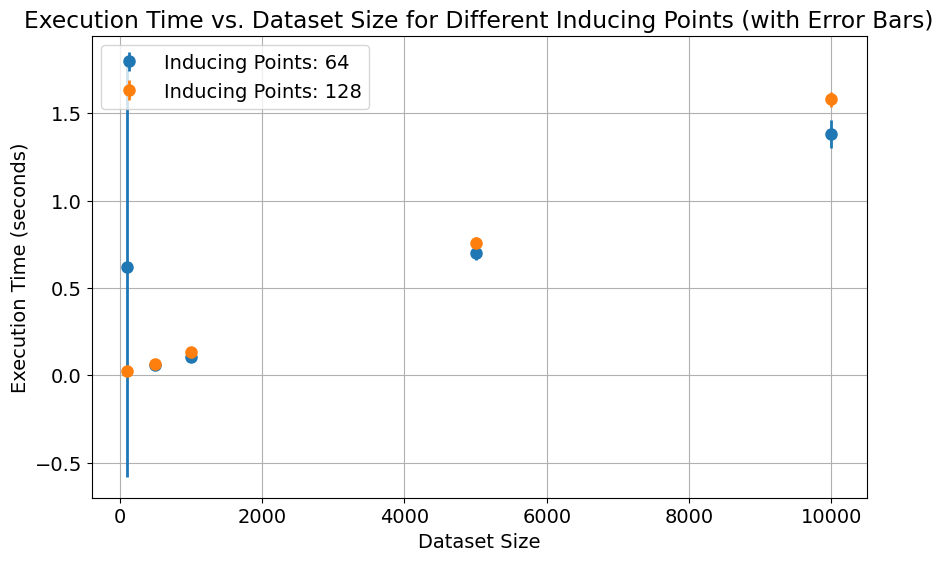

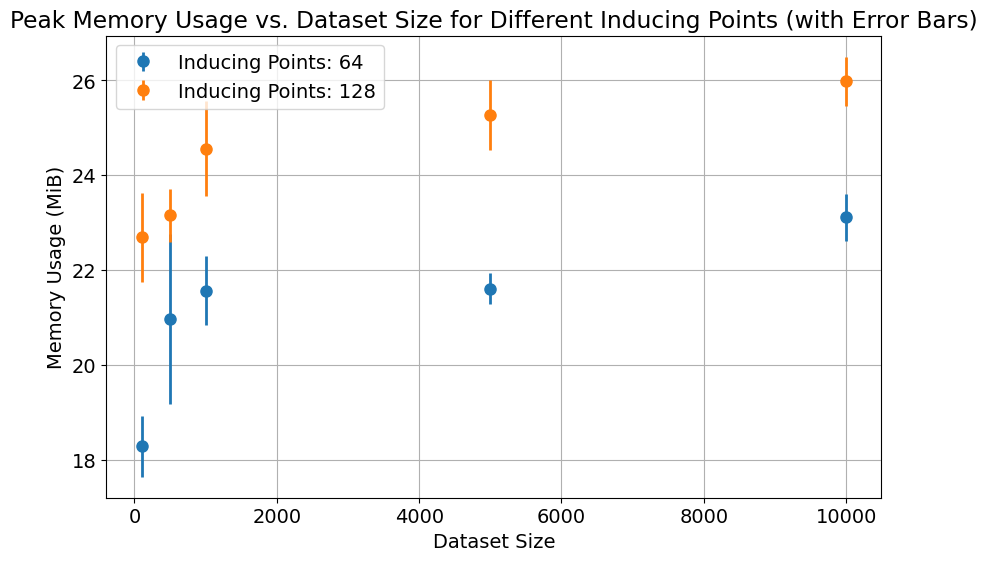

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import time
import numpy as np
import matplotlib.pyplot as plt
import pynvml
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlShutdown
from gp.fitgp import GPFitter
from gp.deepgp import DeepGPModel
# Set font and line sizes
plt.rcParams.update({'font.size': 14, 'lines.linewidth': 2, 'lines.markersize': 8})

# Initialize NVML
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)  # Assuming GPU 0

def gpu_memory_usage():
    """
    Assumes only one GPU is available.
    Uses the NVIDIA Management Library to return GPU memory usage information.
    :return: Returns the total amount of VRAM available on the GPU and the VRAM usage.
    """
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # Assuming you have only one GPU
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    total_memory = mem_info.total  # in bytes
    used_memory = mem_info.used  # in bytes
    pynvml.nvmlShutdown()
    return total_memory / (1024 ** 3), used_memory / (1024 ** 3)  # Convert bytes to gigabytes

def benchmark_gp_gpu(dataset_sizes, dim=4, num_runs=5):
    pass

def benchmark_deepgp_gpu(dataset_sizes, inducing_points_list, dim=4, num_runs=5):
    time_results = np.zeros((len(dataset_sizes), len(inducing_points_list), num_runs))
    memory_results = np.zeros((len(dataset_sizes), len(inducing_points_list), num_runs))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for i, dataset_size in enumerate(dataset_sizes):
        train_x = torch.randn(dataset_size, dim, device=device, dtype=torch.double)
        train_y = torch.randn(dataset_size, 1, device=device, dtype=torch.double)

        for j, num_inducing_points in enumerate(inducing_points_list):
            for k in range(num_runs):
                model = DeepGPModel(
                    train_x_shape=train_x.shape,
                    hidden_layers_config=[{'output_dims': None, 'mean_type': 'constant'}],  # Example config
                    num_inducing_points=num_inducing_points
                ).to(device)

                # Profile memory usage during training
                torch.cuda.reset_peak_memory_stats()
                torch.cuda.synchronize()

                start_time = time.time()

                # Fit model using GPFitter
                GPFitter()(model,
                           train_x,
                           train_y,
                           "deep_gp",
                           batch_size=128,
                           num_batches=dataset_size // 128,
                           num_epochs=1)
                
                torch.cuda.synchronize()
                end_time = time.time()
                execution_time = end_time - start_time

                memory_usage = torch.cuda.max_memory_allocated() / 1024 ** 2  # Peak memory usage in MiB

                # Record results
                time_results[i, j, k] = execution_time
                memory_results[i, j, k] = memory_usage

    return time_results, memory_results

# Example usage
dataset_sizes = [100, 500, 1000, 5000, 10000]  # Example dataset sizes
inducing_points_list = [64, 128]  # Example inducing points
num_runs = 5  # Number of runs for error bars
time_results, memory_results = benchmark_deepgp_gpu(dataset_sizes, inducing_points_list, num_runs=num_runs)

# Shutdown NVML
nvmlShutdown()

# Calculate means and standard deviations for error bars
time_means = np.mean(time_results, axis=2)
time_stddevs = np.std(time_results, axis=2)
memory_means = np.mean(memory_results, axis=2)
memory_stddevs = np.std(memory_results, axis=2)

# Plotting results with error bars (time)
plt.figure(figsize=(10, 6))
for j, num_inducing_points in enumerate(inducing_points_list):
    plt.errorbar(dataset_sizes, time_means[:, j], yerr=time_stddevs[:, j], fmt='o', label=f'Inducing Points: {num_inducing_points}')
plt.xlabel('Dataset Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs. Dataset Size for Different Inducing Points (with Error Bars)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting results with error bars (memory)
plt.figure(figsize=(10, 6))
for j, num_inducing_points in enumerate(inducing_points_list):
    plt.errorbar(dataset_sizes, memory_means[:, j], yerr=memory_stddevs[:, j], fmt='o', label=f'Inducing Points: {num_inducing_points}')
plt.xlabel('Dataset Size')
plt.ylabel('Memory Usage (MiB)')
plt.title('Peak Memory Usage vs. Dataset Size for Different Inducing Points (with Error Bars)')
plt.legend()
plt.grid(True)
plt.show()


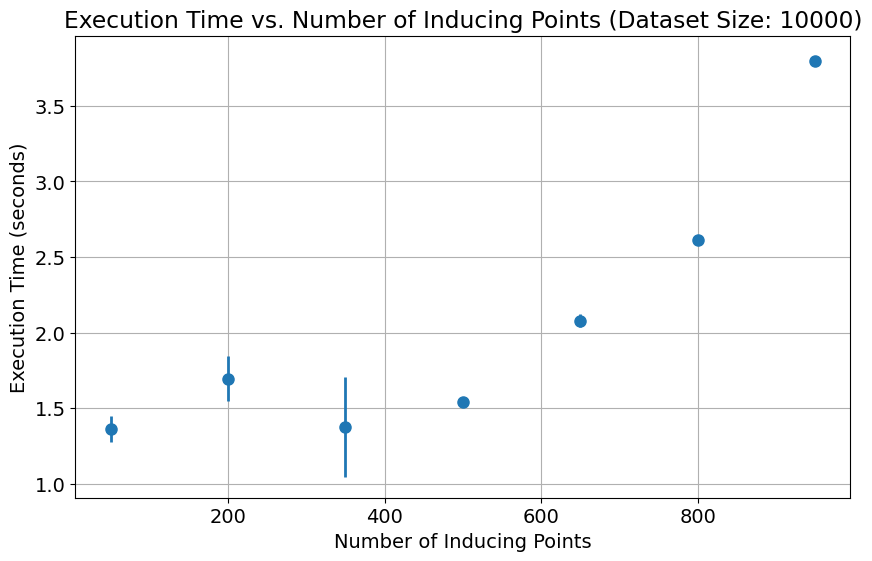

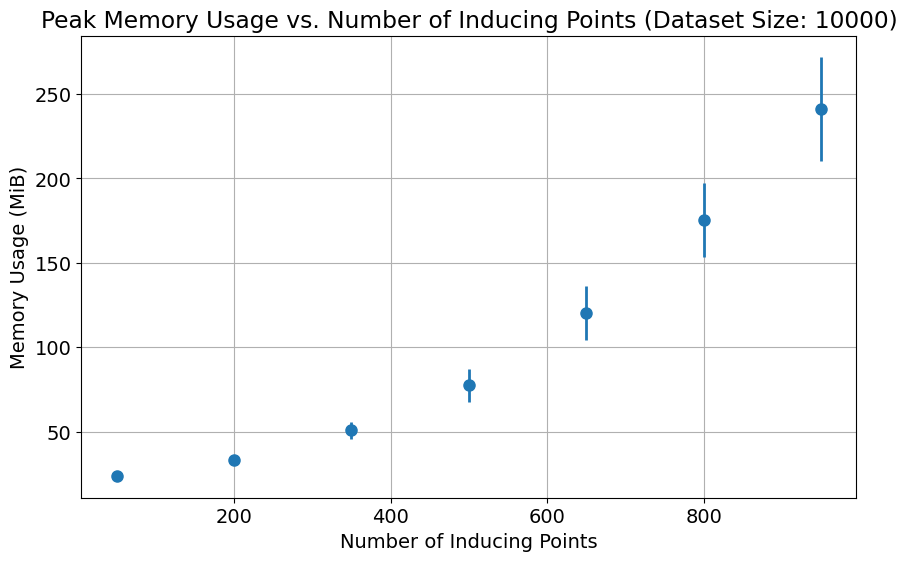

In [2]:
# Example usage
dataset_size = 10000  # Fixed dataset size
inducing_points_list = [50,200,350,500,650,800,950] #[32, 102, 172, 242, 312, 382, 452, 512, 572, 632]
  # Example inducing points
num_runs = 10  # Number of runs for error bars
time_results, memory_results = benchmark_deepgp_gpu([dataset_size], inducing_points_list, num_runs=num_runs)

# Shutdown NVML
nvmlShutdown()

# Calculate means and standard deviations for error bars
time_means = np.mean(time_results[0], axis=1)  # Mean time across runs for the single dataset size
time_stddevs = np.std(time_results[0], axis=1)  # Standard deviation of time across runs for the single dataset size
memory_means = np.mean(memory_results[0], axis=1)  # Mean memory across runs for the single dataset size
memory_stddevs = np.std(memory_results[0], axis=1)  # Standard deviation of memory across runs for the single dataset size

# Plotting results with error bars (time)
plt.figure(figsize=(10, 6))
plt.errorbar(inducing_points_list, time_means, yerr=time_stddevs, fmt='o')
plt.xlabel('Number of Inducing Points')
plt.ylabel('Execution Time (seconds)')
plt.title(f'Execution Time vs. Number of Inducing Points (Dataset Size: {dataset_size})')
plt.grid(True)
plt.show()

# Plotting results with error bars (memory)
plt.figure(figsize=(10, 6))
plt.errorbar(inducing_points_list, memory_means, yerr=memory_stddevs, fmt='o')
plt.xlabel('Number of Inducing Points')
plt.ylabel('Memory Usage (MiB)')
plt.title(f'Peak Memory Usage vs. Number of Inducing Points (Dataset Size: {dataset_size})')
plt.grid(True)
plt.show()

In [ ]:
from botorch.models import SingleTaskGP


def benchmark_singletaskgp(dataset_sizes, num_runs=5, dim=4):
    time_results = np.zeros((len(dataset_sizes), num_runs))
    memory_results = np.zeros((len(dataset_sizes), num_runs))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for i, dataset_size in enumerate(dataset_sizes):
        train_x = torch.randn(dataset_size, dim, device=device, dtype=torch.double)
        train_y = torch.randn(dataset_size, 1, device=device, dtype=torch.double)

        for run in range(num_runs):
            model = SingleTaskGP(train_x, train_y).to(device)
            
            # Profile memory usage during training
            torch.cuda.reset_peak_memory_stats()
            torch.cuda.synchronize()

            start_time = time.time()

            # Fit model using GPFitter or fit_gpytorch_model directly
            # Example using GPFitter
            GPFitter()(model, train_x, train_y, "exact_gp")

            # Alternatively, you can use fit_gpytorch_model directly
            # fit_gpytorch_model(model, train_data=TrainingData(train_x, train_y))

            torch.cuda.synchronize()
            end_time = time.time()
            execution_time = end_time - start_time

            memory_usage = torch.cuda.max_memory_allocated() / 1024 ** 2  # Peak memory usage in MiB

            # Record results
            time_results[i, run] = execution_time
            memory_results[i, run] = memory_usage

    return time_results, memory_results

def plot_results(dataset_sizes, time_means, time_stddevs, memory_means, memory_stddevs):
    # Plotting results with error bars (time)
    plt.figure(figsize=(10, 6))
    plt.errorbar(dataset_sizes, time_means, yerr=time_stddevs, fmt='o')
    plt.xlabel('Dataset Size')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Execution Time vs. Dataset Size (SingleTaskGP)')
    plt.grid(True)
    plt.show()

    # Plotting results with error bars (memory)
    plt.figure(figsize=(10, 6))
    plt.errorbar(dataset_sizes, memory_means, yerr=memory_stddevs, fmt='o')
    plt.xlabel('Dataset Size')
    plt.ylabel('Memory Usage (MiB)')
    plt.title('Peak Memory Usage vs. Dataset Size (SingleTaskGP)')
    plt.grid(True)
    plt.show()

# Example usage
dataset_sizes = [100, 1700, 3300, 4900, 6500, 8100, 9700]
num_runs = 10  # Number of runs for error bars
time_results, memory_results = benchmark_singletaskgp(dataset_sizes, num_runs=num_runs)

# Shutdown NVML
nvmlShutdown()

# Calculate means and standard deviations for error bars
time_means = np.mean(time_results, axis=1)  # Mean time across runs for each dataset size
time_stddevs = np.std(time_results, axis=1)  # Standard deviation of time across runs for each dataset size
memory_means = np.mean(memory_results, axis=1)  # Mean memory across runs for each dataset size
memory_stddevs = np.std(memory_results, axis=1)  # Standard deviation of memory across runs for each dataset size

# Plotting results
plot_results(dataset_sizes, time_means, time_stddevs, memory_means, memory_stddevs)

/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0614], device='cuda:0', dtype=torch.float64), std = tensor([1.0160], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0264], device='cuda:0', dtype=torch.float64), std = tensor([0.9799], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
 